# Q1

## Initial Setup

In [1]:
import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt
import dask.array as da

In [2]:
from dask_cloudprovider.aws import EC2Cluster 
from dask.distributed import Client
import configparser
import os
import contextlib
import re
import dask
from platform import python_version

def get_aws_credentials():
    """Read in AWS credentials file and convert to environment variables."""
    parser = configparser.RawConfigParser()
    
    parser.read(os.path.expanduser('~/.aws/config'))
    config = parser.items('default')
    
    parser.read(os.path.expanduser('~/.aws/credentials'))
    credentials = parser.items('default')
    
    all_credentials = {key.upper(): value for key, value in [*config, *credentials]}
    with contextlib.suppress(KeyError):
        all_credentials["AWS_REGION"] = all_credentials.pop("REGION")
        
    return all_credentials

# Pass in AWS Credentials + any extra packages on cluster via `pip`
env_vars = get_aws_credentials()
env_vars["EXTRA_PIP_PACKAGES"] = "s3fs"

# Select software installed on scheduler + worker instances based on client Python + Dask versions
py_v = '-py' + re.findall(r'\d{1}.\d+', python_version())[0]
dask_docker_tag = f"daskdev/dask:{dask.__version__ + py_v}"
print('Docker Image: ', dask_docker_tag)

# launch a cluster of 5 r5.large instances (10 vCPUs):
cluster = EC2Cluster(instance_type='r5.large',
                     n_workers=4,
                     security=False,
                     docker_image=dask_docker_tag,
                     env_vars=env_vars
)

Docker Image:  daskdev/dask:2024.5.0-py3.10
Creating scheduler instance
Created instance i-0201e06ff714327fa as dask-afb17965-scheduler
Waiting for scheduler to run at 54.211.13.128:8786
Scheduler is running


/Users/qxlin/.pyenv/versions/3.10.14/lib/python3.10/contextlib.py:142: UserWarning: Creating your cluster is taking a surprisingly long time. This is likely due to pending resources. Hang tight! 
  next(self.gen)


Creating worker instance
Creating worker instance
Creating worker instance
Creating worker instance
Created instance i-0754ae7df5f881461 as dask-afb17965-worker-8cfb1436
Created instance i-08e5ca784ef248509 as dask-afb17965-worker-82d6a4cb
Created instance i-0a32223603d874f6a as dask-afb17965-worker-6123019b
Created instance i-0a2a6b7df1db9ed00 as dask-afb17965-worker-19a9cc28


In [3]:
client = Client(cluster)
client

/Users/qxlin/Library/CloudStorage/GoogleDrive-qxlin@uchicago.edu/My Drive/UChi/MACS-30123/.venv/lib/python3.10/site-packages/distributed/client.py:1393: VersionMismatchWarning: Mismatched versions found

+---------+-----------------+-----------------+-----------------+
| Package | Client          | Scheduler       | Workers         |
+---------+-----------------+-----------------+-----------------+
| lz4     | None            | 4.3.3           | 4.3.3           |
| msgpack | 1.0.8           | 1.0.7           | 1.0.7           |
| python  | 3.10.14.final.0 | 3.10.12.final.0 | 3.10.12.final.0 |
| toolz   | 0.12.1          | 0.12.0          | 0.12.0          |
+---------+-----------------+-----------------+-----------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


<Client: 'tcp://172.31.81.168:8786' processes=3 threads=6, memory=45.98 GiB>

In [8]:
# Read the data from parquet file
df = dd.read_parquet('s3://nyc-tlc/trip data/yellow_tripdata_2015*.parquet',
                     engine='pyarrow').persist()

In [9]:
# Get basic statistics of the all dataset
df.describe() \
  .compute()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,1.460392e+08,146039231,146039231,1.460392e+08,1.460392e+08,1.460392e+08,1.460392e+08,1.460392e+08,1.460392e+08,1.460392e+08,1.460392e+08,1.460392e+08,1.460392e+08,1.460392e+08,1.460392e+08,1.460392e+08
mean,1.524660e+00,NaN,NaN,1.680858e+00,1.184584e+01,1.041786e+00,1.620416e+02,1.600179e+02,1.378856e+00,1.293904e+01,3.142529e-01,4.976088e-01,1.729140e+00,3.077635e-01,2.983276e-01,1.609726e+01
std,4.993915e-01,NaN,NaN,1.333530e+00,1.093597e+04,6.533164e-01,6.704974e+01,7.066191e+01,4.991914e-01,1.243789e+02,4.529671e-01,4.924381e-02,3.269192e+02,1.646136e+00,2.333346e-02,3.569951e+02
min,1.000000e+00,1970-01-17 10:27:50.400000,1969-12-06 10:23:31.200000,0.000000e+00,-4.084012e+07,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-4.960000e+02,-7.900000e+01,-5.000000e-01,-4.400000e+02,-9.900000e+01,-3.000000e-01,-4.963000e+02
25%,1.000000e+00,1970-01-17 12:26:39.112000,1970-01-17 12:59:39.305000,1.000000e+00,1.050000e+00,1.000000e+00,1.140000e+02,1.070000e+02,1.000000e+00,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,8.800000e+00
50%,2.000000e+00,1970-01-17 14:26:31.569000,1970-01-17 15:43:57.521000,1.000000e+00,1.800000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,1.000000e+01,0.000000e+00,5.000000e-01,1.250000e+00,0.000000e+00,3.000000e-01,1.230000e+01
75%,2.000000e+00,1970-01-17 16:50:08.941000,1970-01-17 18:13:54.352000,2.000000e+00,3.300000e+00,1.000000e+00,2.330000e+02,2.330000e+02,2.000000e+00,1.500000e+01,5.000000e-01,5.000000e-01,2.360000e+00,0.000000e+00,3.000000e-01,1.835000e+01
max,2.000000e+00,1970-01-17 19:13:26.399000,1970-04-14 14:21:35.798000,9.000000e+00,5.901661e+07,9.900000e+01,2.650000e+02,2.650000e+02,5.000000e+00,8.259986e+05,6.524200e+02,9.100000e+01,3.950589e+06,1.901400e+03,7.000000e-01,3.950612e+06


In [12]:
# Clean the data
df = df.query('tip_amount >= 0 and tip_amount <= 2000').persist()

## Visualization

### Visualization1: Histogram of Tip Amounts

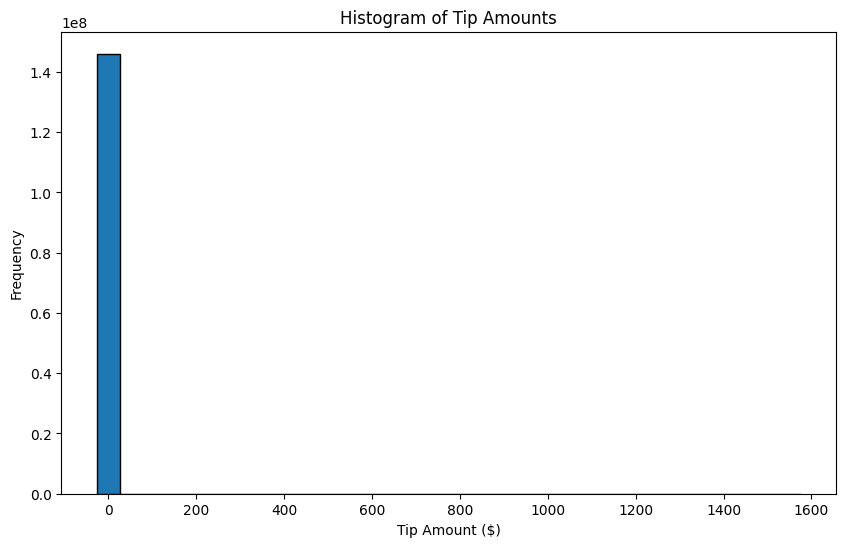

In [7]:
tip_amount_array = df['tip_amount'].to_dask_array(lengths=True)

# Define the range dynamically if needed by computing the maximum when needed
tip_max = df['tip_amount'].max().compute()

# Calculate the histogram using the Dask array
hist, bin_edges = da.histogram(tip_amount_array, bins=30, range=(0, tip_max))

# Cmpute the histogram and bin edges to use in plotting
hist_computed, bin_edges_computed = hist.compute(), bin_edges

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(bin_edges_computed[:-1], hist_computed, width=np.diff(bin_edges_computed), edgecolor='black')
plt.title('Histogram of Tip Amounts')
plt.xlabel('Tip Amount ($)')
plt.ylabel('Frequency')
plt.show()

In [13]:
# Compute basic statistics to understand the distribution of tip amount
stats = df['tip_amount'].describe().compute()
print(stats)

count    1.460382e+08
mean     1.702145e+00
std      2.587887e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.250000e+00
75%      2.360000e+00
max      1.603050e+03
Name: tip_amount, dtype: float64


In [14]:
# Remove or cap outliers 
tip_cap = df['tip_amount'].quantile(0.99).compute()  # Cap at the 99th percentile
df = df[df['tip_amount'] <= tip_cap]

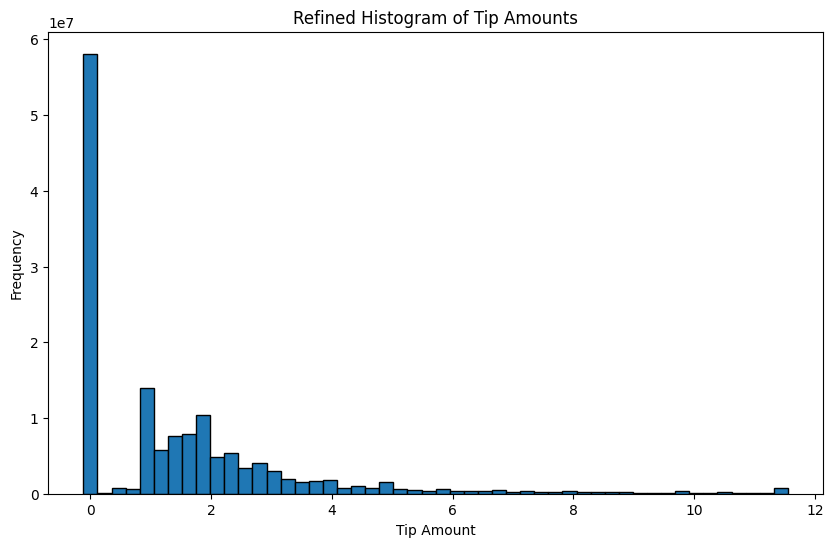

In [15]:
# Convert to Dask array again after modifications
tip_amount_array = df['tip_amount'].to_dask_array(lengths=True)

# Calculate histogram with potentially more appropriate range
hist, bin_edges = da.histogram(tip_amount_array, bins=50, range=(0, tip_cap))

# Compute the histogram data
hist_computed, bin_edges_computed = hist.compute(), bin_edges

# Plot the histogram again
plt.figure(figsize=(10, 6))
plt.bar(bin_edges_computed[:-1], hist_computed, width=np.diff(bin_edges_computed), edgecolor='black')
plt.title('Refined Histogram of Tip Amounts')
plt.xlabel('Tip Amount')
plt.ylabel('Frequency')
plt.show()

This histogram displays the distribution of tip amounts for NYC taxi trips. The majority of trips have a tip amount of zero, with a noticeable drop-off as the tip amount increases. The significant frequency of zero tips and the general trend toward lower tip amounts suggest that many passengers do not tip, and those who do typically leave modest tips.

### Visualization2: Scatter plot of Trip Distance vs. Tip Amount

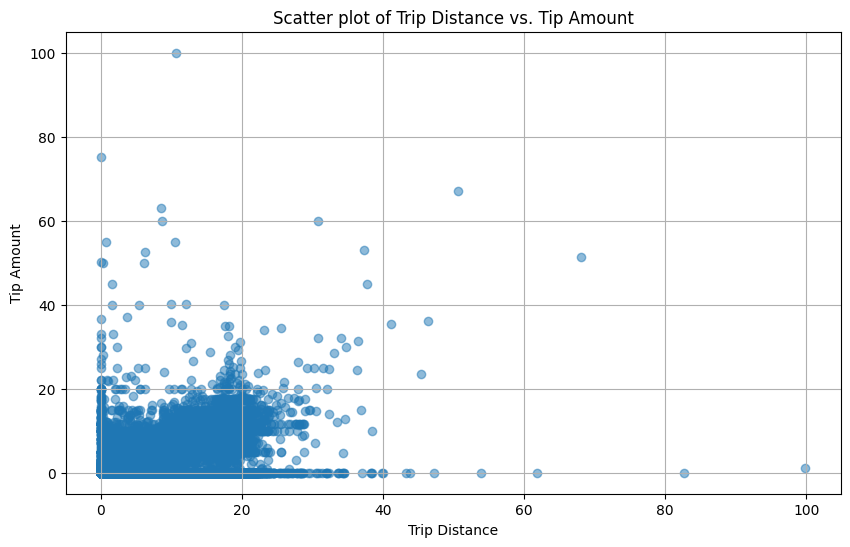

In [26]:
# Reading data from S3 into a Dask DataFrame and clean it
df = dd.read_parquet('s3://nyc-tlc/trip data/yellow_tripdata_2015*.parquet',
                     engine='pyarrow').persist()
df = df.query('tip_amount >= 0 and tip_amount <= 2000').persist()

# Using a smaller fraction and visualizing before computing
sampled_df = df[['trip_distance', 'tip_amount']].sample(frac=0.001)

# Compute with progress bar
pdf = sampled_df.compute()

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(pdf['trip_distance'], pdf['tip_amount'], alpha=0.5)
plt.title('Scatter plot of Trip Distance vs. Tip Amount')
plt.xlabel('Trip Distance')
plt.ylabel('Tip Amount')
plt.grid(True)
plt.show()


This scatter plot provides a detailed visualization of the relationship between trip distance and tip amount, revealing a dense cluster of trips under 20 miles with tips generally below $40. Notably, the plot shows a decline in higher tip amounts as trip distance increases, indicating that longer trips may not necessarily result in proportionally higher tips, which could be influenced by factors such as fare structure or passenger expectations.

### Visualiation3: Average Tip Amount by Hour of Pickup

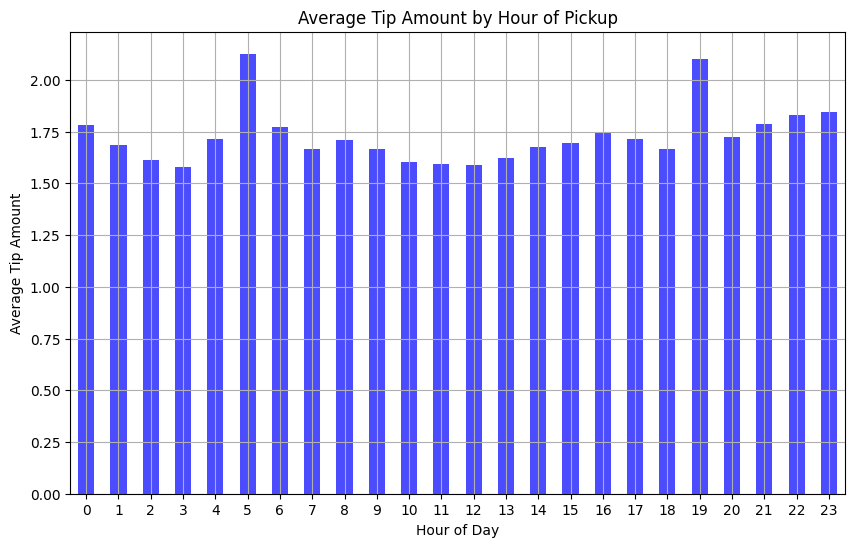

In [ ]:
# Convert 'pickup_datetime' to datetime type
df['tpep_pickup_datetime'] = dd.to_datetime(df['tpep_pickup_datetime'])

# Extract the hour from 'pickup_datetime'
df['hour'] = df['tpep_pickup_datetime'].dt.hour

# Group by the hour, compute the mean of 'tip_amount', compute the result, and plot
result = df.groupby('hour')['tip_amount'].mean().compute()

# Plot
plt.figure(figsize=(10, 6))
result.plot(kind='bar', color='blue', alpha=0.7)
plt.title('Average Tip Amount by Hour of Pickup')
plt.xlabel('Hour of Day')
plt.ylabel('Average Tip Amount')
plt.grid(True)
plt.xticks(rotation=0)
plt.show()


This bar chart illustrates the average tip amount for NYC taxi trips by the hour of pickup. The data reveals that tips tend to be higher during early morning hours (around 5-6 AM) and late evening hours (around 7-8 PM). This pattern may be influenced by different passenger behaviors and trip purposes at these times, such as airport trips or evening outings, which could be important factors for predicting tip amounts.

### visualization4: Average Tip Amount by Day of Week

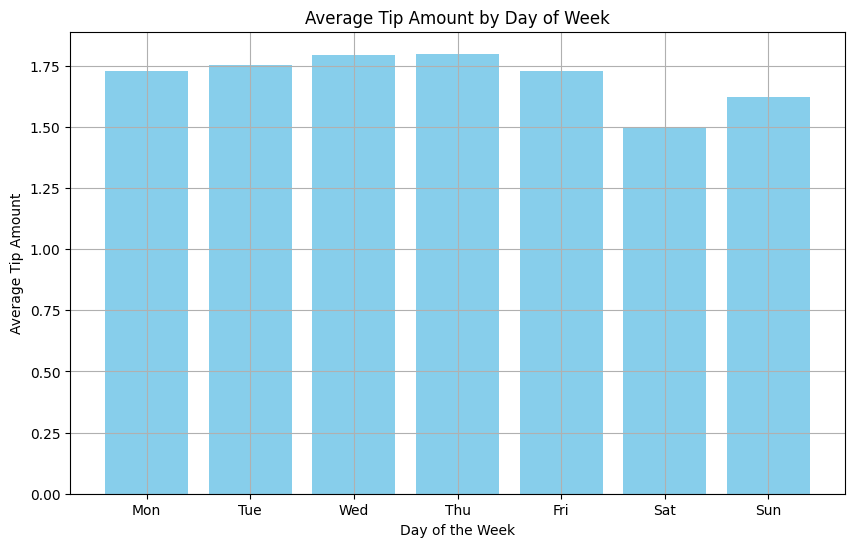

In [35]:
# Get the day_of_week feature
df['day_of_week'] = df['tpep_pickup_datetime'].dt.dayofweek
result = df.groupby('day_of_week')['tip_amount'].mean().compute()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(result.index, result.values, color='skyblue')
plt.xlabel('Day of the Week')
plt.ylabel('Average Tip Amount')
plt.title('Average Tip Amount by Day of Week')
plt.xticks(ticks=result.index, labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.grid(True)
plt.show()


This bar chart shows the average tip amount received by NYC taxi drivers for each day of the week, highlighting a relatively consistent tipping pattern across the days with slight variations. Interestingly, the visualization indicates that people tend to tip slightly less during the weekend compared to weekdays.

### Visualization5: Average Tip Amount by Passenger Count

In [34]:
# Calculate avergae tip amount by number of passengers
tip_amount_by_passenger_count = df[['tip_amount', 'passenger_count']].groupby('passenger_count') \
                                                                      .mean()
tip_amount_by_passenger_count = tip_amount_by_passenger_count.compute()

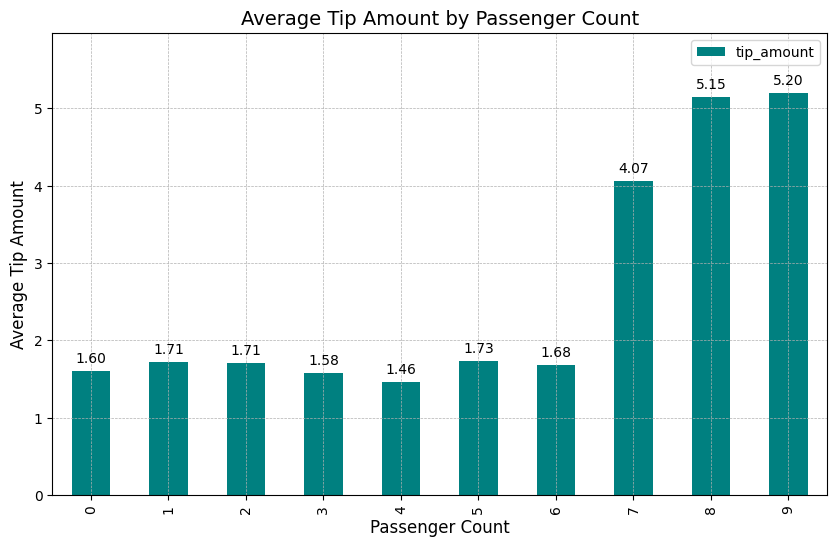

In [33]:
# Set the plot
fig, ax = plt.subplots(figsize=(10, 6))
tip_amount_by_passenger_count.plot(kind='bar', color='teal', ax=ax)
ax.set_xlabel('Passenger Count', fontsize=12)
ax.set_ylabel('Average Tip Amount', fontsize=12)
ax.set_title('Average Tip Amount by Passenger Count', fontsize=14)

# Add value annotations
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

# Set y-axis limit and add a grid
ax.set_ylim(0, max(tip_amount_by_passenger_count['tip_amount']) * 1.15)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plot
plt.show()

This bar chart illustrates the average tip amount for NYC taxi trips based on the number of passengers. The data shows that trips with higher passenger counts, particularly those with 7 or more passengers, tend to receive significantly higher tips. This pattern suggests that larger groups are more likely to tip generously, which could be due to shared payment dynamics or group influence.

### Visualization6: Histogram of Trip Distances

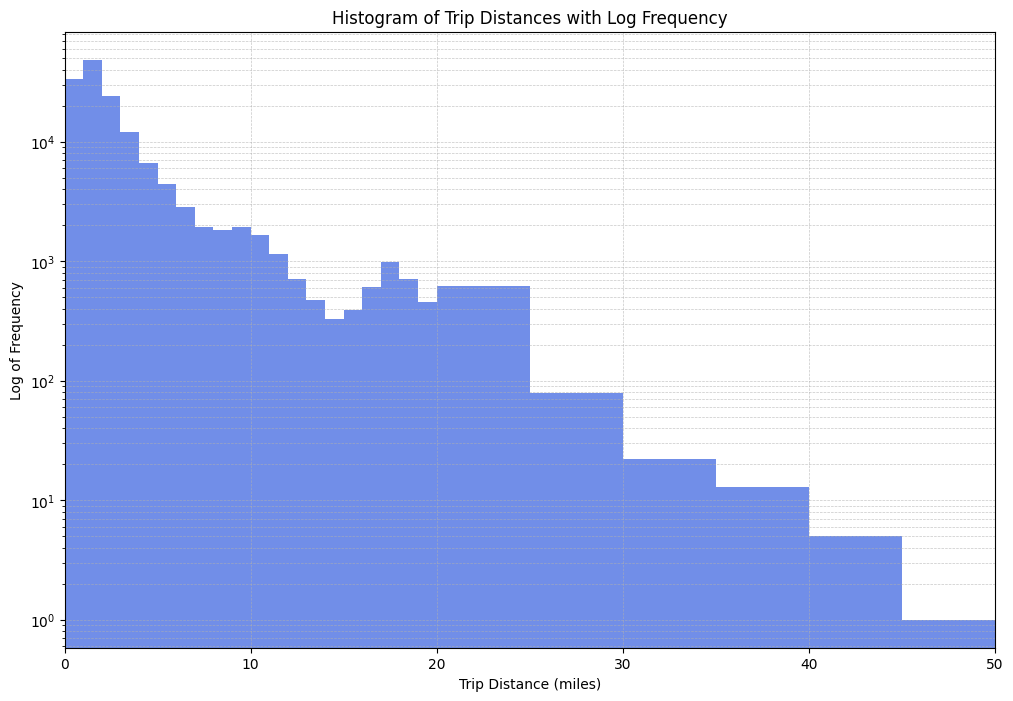

In [43]:
trip_distance_sample = df['trip_distance'].sample(frac=0.001).compute()

# Define uniform bin widths for clarity
bins = list(range(0, 20)) + list(range(20, 50, 5)) + list(range(50, 100, 10))

plt.figure(figsize=(12, 8))
plt.hist(trip_distance_sample, bins=bins, color='royalblue', alpha=0.75, log=True)
plt.title('Histogram of Trip Distances with Log Frequency')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Log of Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xlim([0, 50])

plt.show()


The majority of trips are concentrated in the shorter range, particularly under 10 miles, with the frequency sharply decreasing for longer distances. The log scale helps to illustrate the vast difference in the number of short versus long trips, highlighting the rarity of trips over 30 miles within the dataset - short trips are far more common than longer ones in the urban setting of New York City.

In [44]:
cluster.close()

Terminated dask-afb17965-worker-8cfb1436 (i-0754ae7df5f881461)
Terminated dask-afb17965-worker-82d6a4cb (i-08e5ca784ef248509)
Terminated dask-afb17965-worker-6123019b (i-0a32223603d874f6a)
Terminated dask-afb17965-worker-19a9cc28 (i-0a2a6b7df1db9ed00)
Terminated dask-afb17965-scheduler (i-0201e06ff714327fa)
